> This notebook contains the summary of Joe's note and also other relevant information as to how run the Matlab scripts. 
> It also attempts to correct some typos present in the notes. 

In [6]:
import pathlib 
import re 
import glob 
import numbers 
import sys 

import numpy as np 
import scipy as sp 
import h5py 
import xarray as xr 
import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable


root_dir = pathlib.Path(pathlib.Path.cwd()).resolve().parent 
#print(f"Root directory is {root_dir}") 

imgsdir = f"{root_dir}/imgs"
if not pathlib.Path(imgsdir).exists():
    pathlib.Path(imgsdir).mkdir() 
    print(f"Created {imgsdir}")


def reconstruct_data(array): 

    real_part = np.array([[elem[0] for elem in row] for row in array])
    imag_part = np.array([[elem[1] for elem in row] for row in array])
    
    return real_part + 1j * imag_part


def find_repo_root(start_path: pathlib.Path = None) -> pathlib.Path:
    # If no start path is provided, use the current working directory
    if start_path is None:
        start_path = pathlib.Path.cwd()
    
    # Convert to absolute path
    start_path = start_path.resolve()
    
    # Check each directory from the start path upwards to the root
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').is_dir():
            return parent
    
    raise FileNotFoundError("No .git directory found in any parent directories")

repo_root = find_repo_root()
print(f"The root of the repo is: {repo_root}")

The root of the repo is: /run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-91


The Matlab scripts are run in the following sequence: 

1. `apconv.m` --- parses antenna pattern
2. `proc_all.apats.m` --- interpolates antenna pattern onto a plane (conversion from tilted to untilted director cosine coordinate system)
3. `flip_v.m` --- flips the antenna pattern in `v`  on the (u,v) grid. [**Note**]: HAVEN'T USED YET, IGNORE FOR NOW.
4. `cimrProject` --- projects antenna pattern onto the Earth surface and integrates 
5. ``

#### 1. Convert Antenna Patterns (`.grd`) files into Matlab format

TODO: Add Theory

Run `apconv.m`  that __depends on__: 
- `read_rgd_uv.m`

__Input__ beam file format 
```
Ka4-3650-H-BK.grd
Ka4-3650-H-FR.grd
```
where: 

- `Ka` - the name of the band 
- `4`  - horn number 
- `3650` - central frequency of the channel (36.5 GHz in case of Ka band) 
- `H` - horizontal polarization 
- `BK` - Backward (i.e., BHS)
- `FR` - Forward (i.e., FHS)
- `grd` - GRASP format for grid (see user manual)

__Output__ file format: 
```
cimr_apat_xe_full_C_Horn_02.mat: 
horns/C_Horn_02_FHS/apat/hpol_cxpol: (2501 x 2501), double
			         	 hpol_copol: (2501 x 2501), double 
			             vpol_copol: (2501 x 2501), double 
			             vpol_copol: (2501 x 2501), double 
			             u0: 	(2501 x 2501), double
                         v0: 	(2501 x 2501), double
			             du: 	scalar, 	   double
			             dv: 	scalar, 	   double
			             u: 	(2501 x 2501), double
			             v: 	(2501 x 2501), double

      /C_Horn_02_BHS/… 
```
- `FHS`/`BHS` — Front Half Space / Back Half Space
- `h`/`v` - horizontal/vertical polarization. 
- `?pol_??pol` — component of the electric field amplitude (`?` is `h`/`v`, `??` is `co`/`cx` (Ludwig's 3d definition))
- `du`/`dv`    — the grid step 
- `u`/`v`      — grid 
- `u0`/`v0`    — other grid (???)

[**Note**]: In reality, these should be called not `u` and `v` but `xi` and `eta` since the coordinates are in the tilted reference frame. The next step is what actually converts `xi` and `eta` into `u` and `v`. Also, we were not given a vertical component, only horizontal one; thus, we code copies the horizontal component and call it vertical. 

/tmp/ipykernel_3391/1465101865.py:50: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)
/tmp/ipykernel_3391/1465101865.py:82: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')


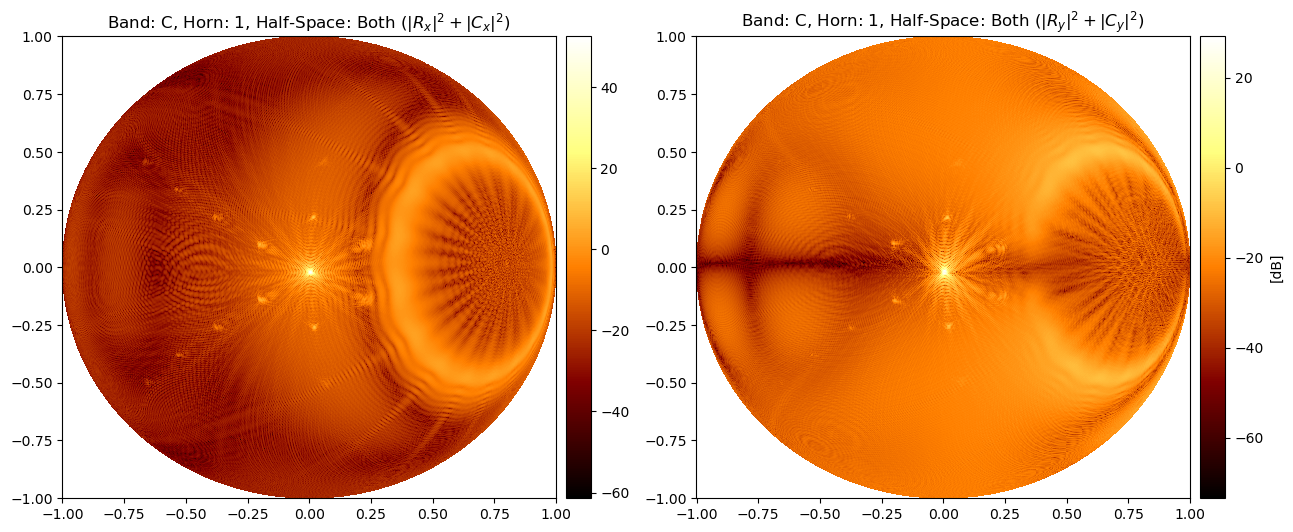

In [3]:
# Opening Joe's data 
# [Note]: Scipy is not able to open matlab v7.3 files, so we are using HDF5 instead
# 
# The files Joe sent us are in v7.3,s o you will have to use the following code to open them
#
# datafile = pathlib.Path(f'{root_dir}/output/parsed/cimr_apat_xe_full.C_Horn_01.mat').resolve()
# cimr = h5py.File(datafile, 'r')
# 
# However, GNU Octave is not able to produce the v7.3, only v7, so if you run the script with that, 
# then you will have to use this one instead

datafile = pathlib.Path(f'{root_dir}/output/parsed/cimr_apat_xe_full.C_Horn_01.mat').resolve()
cimr     = sp.io.loadmat(datafile)

# Co- Pattern 

# v7.3
# cimr_bhs_hcopol = cimr['horns']['C_Horn_01_BHS']['apat']['hpol_copol'][:]
# cimr_fhs_hcopol = cimr['horns']['C_Horn_01_FHS']['apat']['hpol_copol'][:]

# We need to reconstruct the comples array because HDF is not able to work with it by design 
# BHS_Hpol_copol = reconstruct_data(cimr_bhs_hcopol)
# FHS_Hpol_copol = reconstruct_data(cimr_fhs_hcopol)

# u_grid = cimr['horns']['C_Horn_01_BHS']['apat']['u'][:]
# v_grid = cimr['horns']['C_Horn_01_BHS']['apat']['v'][:] 

# v7
cimr_bhs_hcopol = cimr['horns'][0][0]['C_Horn_01_BHS'][0][0]['apat']['hpol_copol'][0][0]
cimr_fhs_hcopol = cimr['horns'][0][0]['C_Horn_01_FHS'][0][0]['apat']['hpol_copol'][0][0]

BHS_Hpol_copol = cimr_bhs_hcopol 
FHS_Hpol_copol = cimr_fhs_hcopol

u_grid = cimr['horns'][0][0]['C_Horn_01_BHS'][0][0]['apat']['u'][0][0]
v_grid = cimr['horns'][0][0]['C_Horn_01_BHS'][0][0]['apat']['v'][0][0] 

# print(np.shape(u_grid))
# print(np.shape(BHS_Hpol_copol))

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 
Z_plt = 10 * np.log10(np.abs(BHS_Hpol_copol)**2 + np.abs(FHS_Hpol_copol)**2)
pcm2 = axes[0].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[0].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_x|^2 + |C_x|^2)$')

# Create a shared color bar
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

# Cx- Pattern 

# v7.3
# cimr_bhs_hcxpol = cimr['horns']['C_Horn_01_BHS']['apat']['hpol_cxpol'][:]
# cimr_fhs_hcxpol = cimr['horns']['C_Horn_01_FHS']['apat']['hpol_cxpol'][:]

# BHS_Hpol_cxpol = reconstruct_data(cimr_bhs_hcxpol)
# FHS_Hpol_cxpol = reconstruct_data(cimr_fhs_hcxpol)

# u_grid = cimr['horns']['C_Horn_01_BHS']['apat']['u'][:]
# v_grid = cimr['horns']['C_Horn_01_BHS']['apat']['v'][:] 

# v7 
cimr_bhs_hcxpol = cimr['horns'][0][0]['C_Horn_01_BHS'][0][0]['apat']['hpol_cxpol'][0][0]
cimr_fhs_hcxpol = cimr['horns'][0][0]['C_Horn_01_FHS'][0][0]['apat']['hpol_cxpol'][0][0]

BHS_Hpol_cxpol = cimr_bhs_hcxpol 
FHS_Hpol_cxpol = cimr_fhs_hcxpol

u_grid = cimr['horns'][0][0]['C_Horn_01_BHS'][0][0]['apat']['u'][0][0]
v_grid = cimr['horns'][0][0]['C_Horn_01_BHS'][0][0]['apat']['v'][0][0] 

Z_plt = 10 * np.log10(np.abs(BHS_Hpol_cxpol)**2 + np.abs(FHS_Hpol_cxpol)**2)
pcm2 = axes[1].pcolor(u_grid, v_grid, Z_plt, cmap='afmhot')#'PuBu')
#pcm2 = axes.pcolor(x, y, Z_plt, shading='auto')
axes[1].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_y|^2 + |C_y|^2)$')#, Units: [dB]')

# Create a shared color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')

# Saving figure
plt.savefig(f'{imgsdir}/cimr_apat_full_C_horn_01_xe.png', dpi=300) 
plt.show()

# v7.3
# cimr.close()

Our Python implementation gives us

/tmp/ipykernel_265468/1386203992.py:24: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)
/tmp/ipykernel_265468/1386203992.py:38: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')


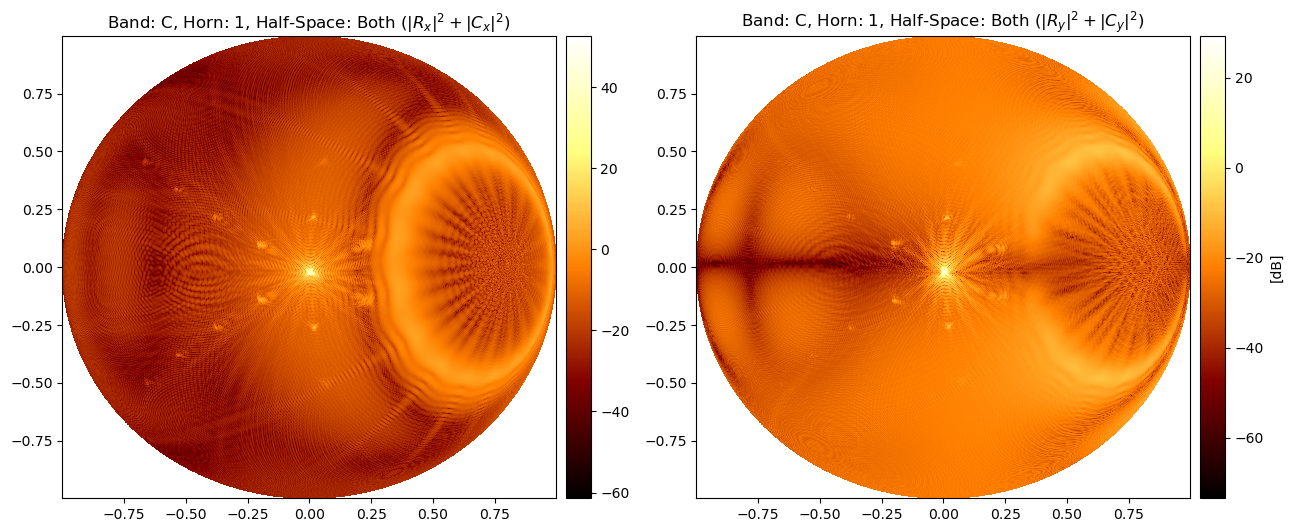

In [9]:
datafile = pathlib.Path(f'{repo_root}/output/parsed/CIMR-AP-FULL-C1-XE.mat').resolve()
cimr     = sp.io.loadmat(datafile)

#u_grid = cimr['BHS']['u_grid'][0][0] 
#v_grid = cimr['BHS']['v_grid'][0][0] 

u_grid = cimr['BHS']['u0'][0][0] 
v_grid = cimr['BHS']['v0'][0][0] 

# Co- Pattern 

BHS_Hpol_copol = cimr['BHS']['hpol_copol'][0][0]
FHS_Hpol_copol = cimr['FHS']['hpol_copol'][0][0]

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 
Z_plt = 10 * np.log10(np.abs(BHS_Hpol_copol)**2 + np.abs(FHS_Hpol_copol)**2)
pcm2 = axes[0].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[0].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_x|^2 + |C_x|^2)$')

# Create a shared color bar
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

# Cx- Pattern 
BHS_Hpol_cxpol = cimr['BHS']['hpol_cxpol'][0][0]
FHS_Hpol_cxpol = cimr['FHS']['hpol_cxpol'][0][0]

Z_plt = 10 * np.log10(np.abs(BHS_Hpol_cxpol)**2 + np.abs(FHS_Hpol_cxpol)**2)
pcm2 = axes[1].pcolor(u_grid, v_grid, Z_plt, cmap='afmhot')#'PuBu')
#pcm2 = axes.pcolor(x, y, Z_plt, shading='auto')
axes[1].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_y|^2 + |C_y|^2)$')#, Units: [dB]')

# Create a shared color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')

plt.savefig(f'{imgsdir}/CIMR-AP-FULL-C1-XE.png', dpi=300) 
plt.show()

#### 2. Untilt and downsample antenna patterns

TODO: Add Theory

Run `proc_all_apats.m` (the actual work is done by `proc_apats.m`, so examine this file thoroughly) that __depends on__: 
- `proc_apat.m`
- `trans_apat_fhs_bhs_fast.m`
- `apat_normalize.m`
- `apat_tilt.m`
- `xe_to_uv.m`
- `flip_apat_y.m`
- `rot_apat.m`
- `rot_uv2.m`
- `rot_uv.m`
- `uv_to_xe.m`
- `apat_interp.m`
- `uv_to_fs.m`
- `apat_griddata.m`
- `apat_downsample.m`
 

__Input__ file: 
```
cimr_apat_xe_full_C_Horn_02.mat 
```
__Output__ file(s) format(s): 
```
cimr_apat_hbs.C_Horn_01.ds_003.uv.mat: 
horns/C_Horn_01/apat/du: 		scalar, double
                     dv: 		scalar, double
			          u: 		(500 x 500), double 
			          v: 	        (500 x 500), double 
			          hpol_copol:	(500 x 500), double 
			          hpol_cxpol:  	(500 x 500), double 
			          vpol_copol:  	(500 x 500), double 
			          vpol_cxpol:  	(500 x 500), double 
			          window_half_width: scalar, int 
			          downsample_factor: scalar, int

cimr_apat_hbs.C_Horn_01.ds_003.xe.mat:
horns/C_Horn_01/apat/du: 		scalar, double
                     dv: 		scalar, double
			          u: 		(500 x 500), double 
			          v: 	        (500 x 500), double 
			          hpol_copol:	(500 x 500), double 
			          hpol_cxpol:  	(500 x 500), double 
			          vpol_copol:  	(500 x 500), double 
			          vpol_cxpol:  	(500 x 500), double 
			          window_half_width: scalar, int 
			          downsample_factor: scalar, int
```
- `ds_003` - downsample factor with value `3`
- `u`/`v` - u and v (xi and eta) coordinates (grid values) depending on the file
- `du`/`dv` - grid step

[**Note**]: The downsampling factor is arbitrarily chosen (but it is between 1 and 8 depending on the band).

(0.012744294600634197+0.08010005816359123j)


/tmp/ipykernel_3391/2774933204.py:69: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)
/tmp/ipykernel_3391/2774933204.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')


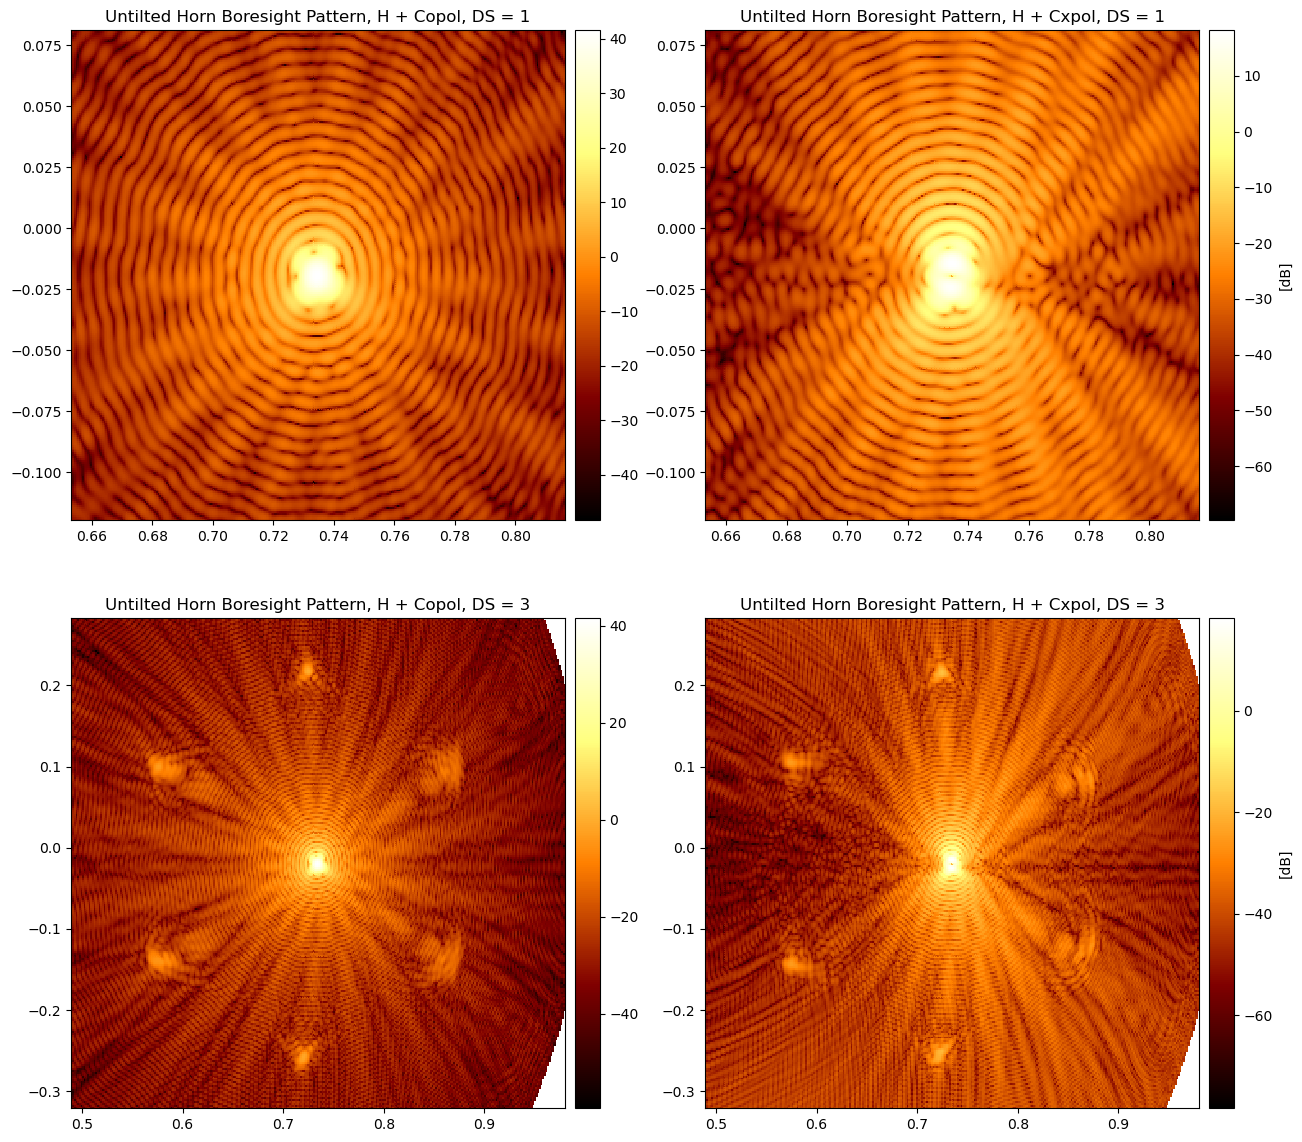

In [5]:
cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(2, 2, figsize=(15,14))

# Opening Joe's data  

# ====================================================================================================
# DS = 1 
# ====================================================================================================

datafile = pathlib.Path(f'{root_dir}/output/processed/cimr_apat_hbs.C_Horn_01.ds_001.uv.mat').resolve()
cimr     = sp.io.loadmat(datafile)

# Grid
u_grid   = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['u'][0][0]
v_grid   = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['v'][0][0]

# Co- Pattern 
Hpol_copol = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_copol'][0][0]

print(Hpol_copol[0][0])

Z_plt = 10 * np.log10(np.abs(Hpol_copol)**2)
pcm2 = axes[0][0].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
# DS = donwsampling factor
axes[0][0].set_title(r'Untilted Horn Boresight Pattern, H + Copol, DS = 1')

# Create a shared color bar
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

# Cx- Pattern 
Hpol_cxpol = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_cxpol'][0][0]

Z_plt = 10 * np.log10(np.abs(Hpol_cxpol)**2)
pcm2 = axes[0][1].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[0][1].set_title(r'Untilted Horn Boresight Pattern, H + Cxpol, DS = 1')

# Create a shared color bar
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')

# ====================================================================================================
# DS = 3 
# ====================================================================================================

datafile = pathlib.Path(f'{root_dir}/output/processed/cimr_apat_hbs.C_Horn_01.ds_003.uv.mat').resolve()
cimr     = sp.io.loadmat(datafile)

# Grid
u_grid   = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['u'][0][0]
v_grid   = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['v'][0][0]


# Co- Pattern 
Hpol_copol = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_copol'][0][0]

#print(cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_copol'][0][0])

Z_plt = 10 * np.log10(np.abs(Hpol_copol)**2)
pcm2 = axes[1][0].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
# DS = donwsampling factor
axes[1][0].set_title(r'Untilted Horn Boresight Pattern, H + Copol, DS = 3')

# Create a shared color bar
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

# Cx- Pattern 
Hpol_cxpol = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_cxpol'][0][0]

Z_plt = 10 * np.log10(np.abs(Hpol_cxpol)**2)
pcm2 = axes[1][1].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[1][1].set_title(r'Untilted Horn Boresight Pattern, H + Cxpol, DS = 3')

# Create a shared color bar
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')

# Saving figure
plt.savefig(f'{imgsdir}/cimr_apat_hbs_C_horn_01_uv.png', dpi=300) 

plt.show() 

We introduced the following file format: 
```
CIMR-AP-HBS-C1-UV.mat 
```
where 
- `CIMR` is axperiment name
- `AP` stands for the Antenna Pattern
- `HBS` is Horn Boresight
- `C1` is C Horn 1
- `UV` is the coordinate system 

Thus, our Python implementation gives us 

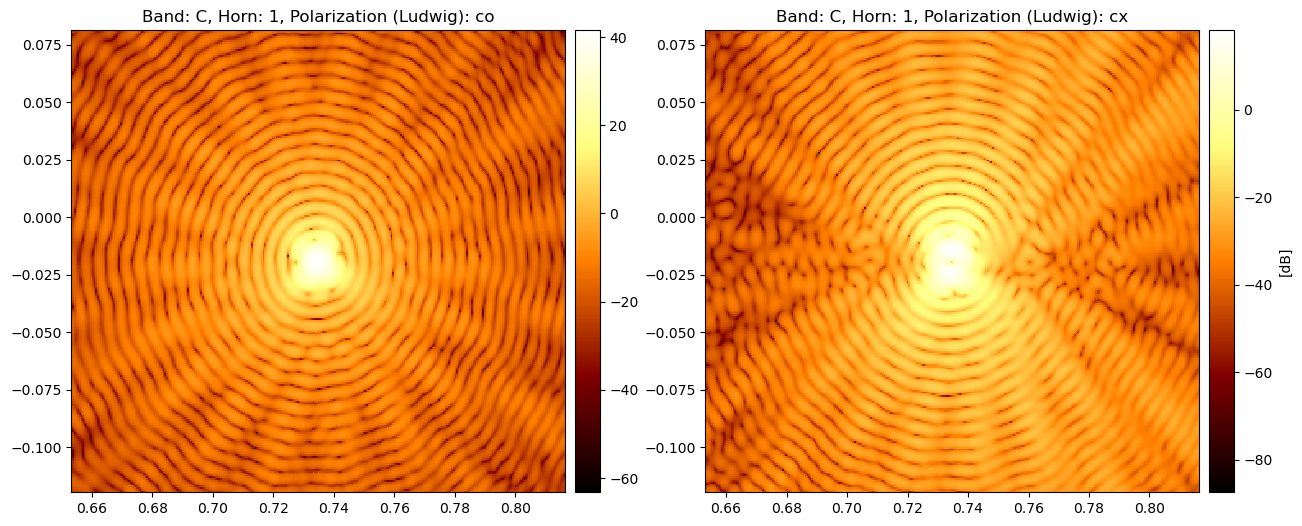

In [6]:
datafile = pathlib.Path(f'{root_dir}/output/processed/CIMR-AP-HBS-C1-UV.mat').resolve()
cimr     = sp.io.loadmat(datafile)

#print(cimr.keys())

#Z1 = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_copol'][0][0]
#Z2 = cimr['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_cxpol'][0][0]
#Z2 = cimr['FHS']['hpol_copol'][0][0]

Hpol_copol = cimr['hpol_copol']
Hpol_cxpol = cimr['hpol_cxpol']

#print(Hpol_copol[0][0])

# Grid
u_grid   = cimr['u']
v_grid   = cimr['v']

cmap = plt.get_cmap('afmhot')#'bone') #'plasma') #'viridis') 
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 
Z_plt = 10 * np.log10(np.abs(Hpol_copol)**2)
pcm2 = axes[0].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
#pcm2 = axes.pcolor(x, y, Z_plt, shading='auto')
axes[0].set_title(r'Band: C, Horn: 1, Polarization (Ludwig): co')#, Units: [dB]')
#axes[0].set_xlabel(r'$\xi$')
#axes[0].set_ylabel(r'$\eta$')

# Create a shared color bar
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax)#, label='Values')

# Cross Pattern 
Z_plt = 10 * np.log10(np.abs(Hpol_cxpol)**2)
pcm2 = axes[1].pcolor(u_grid, v_grid, Z_plt, cmap='afmhot')
#pcm2 = axes.pcolor(x, y, Z_plt, shading='auto')
axes[1].set_title(r'Band: C, Horn: 1, Polarization (Ludwig): cx')#, Units: [dB]')

# Create a shared color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax, label='[dB]')

# Saving figure
#plt.savefig(f'{imgsdir}/cimr_apat_hbs_C_horn_01_uv.png', dpi=300) 

plt.show() 

Difference 

/tmp/ipykernel_3391/2151119741.py:43: RuntimeWarning: invalid value encountered in log10
  Z_plt = 10* np.log10(10 ** (np.log10(np.abs(Hpol_copol_joe)**2)) - 10 ** ( np.log10(np.abs(Hpol_copol_us)**2)))
/tmp/ipykernel_3391/2151119741.py:49: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)#, label='Values')


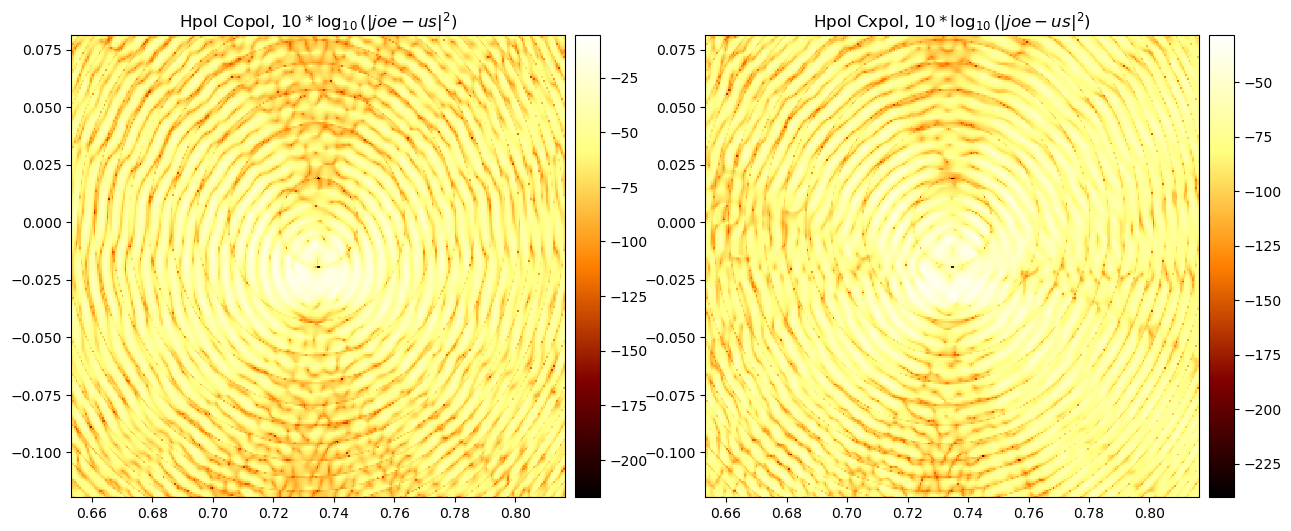

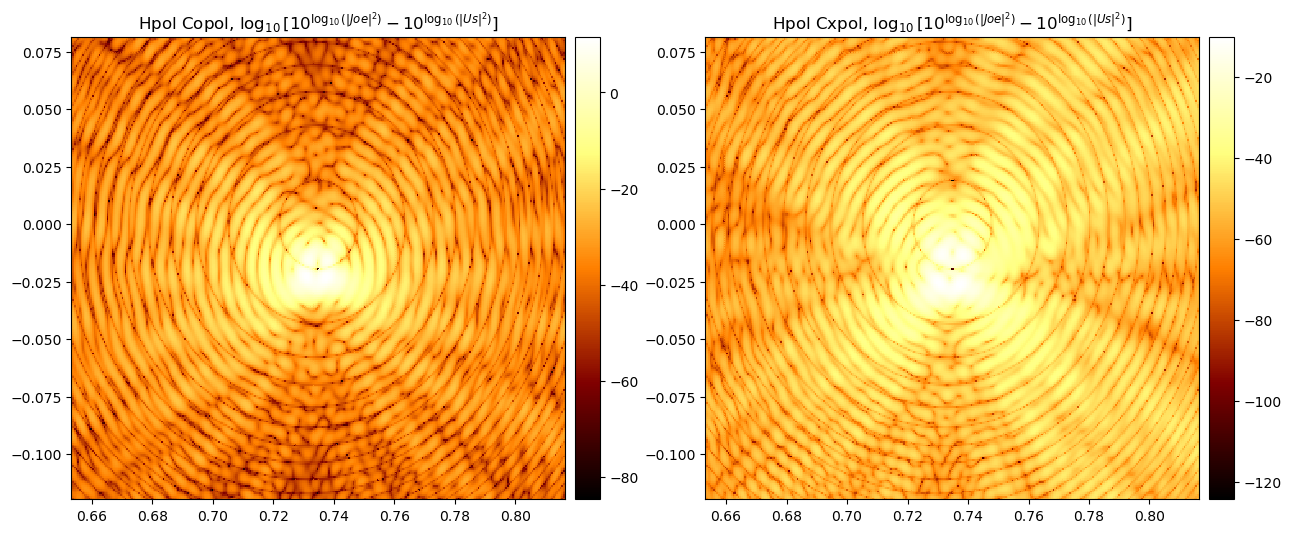

In [7]:
datafile_joe = pathlib.Path(f'{root_dir}/output/processed/cimr_apat_hbs.C_Horn_01.ds_001.uv.mat').resolve()
cimr_joe     = sp.io.loadmat(datafile_joe)

Hpol_copol_joe = cimr_joe['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_copol'][0][0]
Hpol_cxpol_joe = cimr_joe['horns'][0][0]['C_Horn_01'][0][0]['apat']['hpol_cxpol'][0][0]


datafile_us = pathlib.Path(f'{root_dir}/output/processed/CIMR-AP-HBS-C1-UV.mat').resolve()
cimr_us     = sp.io.loadmat(datafile_us)


Hpol_copol_us = cimr_us['hpol_copol']
Hpol_cxpol_us = cimr_us['hpol_cxpol']


# Difference: $10*\log_{10}(|joe - us|^2)$
cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 

Z_plt = 10 * np.log10(np.abs(Hpol_copol_joe - Hpol_copol_us)**2)
pcm2 = axes[0].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[0].set_title(r'Hpol Copol, $10*\log_{10}(|joe - us|^2)$')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax)#, label='Values')


Z_plt = 10 * np.log10(np.abs(Hpol_cxpol_joe - Hpol_cxpol_us)**2)
pcm2 = axes[1].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[1].set_title(r'Hpol Cxpol, $10*\log_{10}(|joe - us|^2)$')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax)#, label='Values')


# Difference: $\log_{10}[10^{\log_{10}(|Joe|^2)} - 10^{\log_{10}(|Us|^2)}]$

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 

Z_plt = 10* np.log10(10 ** (np.log10(np.abs(Hpol_copol_joe)**2)) - 10 ** ( np.log10(np.abs(Hpol_copol_us)**2)))
pcm2 = axes[0].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[0].set_title(r'Hpol Copol, $\log_{10}[10^{\log_{10}(|Joe|^2)} - 10^{\log_{10}(|Us|^2)}]$')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax)#, label='Values')


Z_plt = 10* np.log10(10 ** (np.log10(np.abs(Hpol_cxpol_joe)**2)) - 10 ** ( np.log10(np.abs(Hpol_cxpol_us)**2)))
pcm2 = axes[1].pcolor(u_grid, v_grid, Z_plt, shading='auto', cmap=cmap)
axes[1].set_title(r'Hpol Cxpol, $\log_{10}[10^{\log_{10}(|Joe|^2)} - 10^{\log_{10}(|Us|^2)}]$')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)  # adjust the pad according to your preference
cbar = fig.colorbar(pcm2, cax=cax)#, label='Values')

#### 4. Time averaging of antenna patterns 

Relevant sections in the document are ...

The idea here is to perform averaging of the antenna patterns in several (5) consecutive samples ?? 

....

1. Create directory `integrated` inside `output`

2. Modify the configuration file(s) to point to input/output data (add full path to the `root/output/integrated`):

    - For sample: 
         ```
         % Antenna pattern information.
         fn_apat_hbs_input                  = 'cimr_apat_hbs.C_Horn_01.ds_001.uv.mat'
         fn_apat_hbs_ave                    = 'cimr_apat_hbs.C_Horn_01.ds_001.uv.ave.sample.mat'
         fn_apat_hbs_quicklook              = 'cimr_apat_hbs.C_Horn_01.ds_001.uv.quicklook.sample.mat'
         ```

    - For full: 
        ```
        % Antenna pattern information.
        fn_apat_hbs_input                  = 'cimr_apat_hbs.C_Horn_01.ds_001.uv.mat'
        fn_apat_hbs_ave                    = 'cimr_apat_hbs.C_Horn_01.ds_001.uv.ave.full.mat'
        fn_apat_hbs_quicklook              = 'cimr_apat_hbs.C_Horn_01.ds_001.uv.quicklook.full.mat'
        ```

3. Run the *stand-alone* binary as: 

   - Sample
     ```
     ./cimrProject cimr_orbit_propagator_input_file_C_Horn.hbs_ds_001.sample.cfg sample.mat
     ```
   
   - Full 
     ```
     ./cimrProject cimr_orbit_propagator_input_file_C_Horn.hbs_ds_001.full.cfg full.mat 
     ```

[**Note**]: The output files are of v7.3

__Output__ File: 

```
cimr_apat_hbs.C_Horn_01.ds_001.uv.ave.sample.mat:
C_Horn_01/apat/M33:    (521, 501), double
               M33_sa: scalar, double 
               M34: (521, 501), double
               M34_sa: scalar
               M3x: (521, 501)
               M3x_sa: (1,)
               M3y: (521, 501)
               M3y_sa: (1,)
               M43: (521, 501)
               M43_sa: (1,)
               M44: (521, 501)
               M44_sa: (1,)
               M4x: (521, 501)
               M4x_sa: (1,)
               M4y: (521, 501)
               M4y_sa: (1,)
               Mx3: (521, 501)
               Mx3_sa: (1,)
               Mx4: (521, 501)
               Mx4_sa: (1,)
               Mxx: (521, 501)
               Mxx_sa: (1,)
               Mxy: (521, 501)
               Mxy_sa: (1,)
               My3: (521, 501)
               My3_sa: (1,)
               My4: (521, 501)
               My4_sa: (1,)
               Myx: (521, 501)
               Myx_sa: (1,)
               Myy: (521, 501)
               Myy_sa: (1,)
               cx_i: (521, 501)
               cx_r: (521, 501)
               cy_i: (521, 501)
               cy_r: (521, 501)
               da: (521, 501)
               du: (1,)
               dv: (1,)
               integration_time_ms: (1,)
               pra: (521, 501)
               rx_i: (521, 501)
               rx_r: (521, 501)
               ry_i: (521, 501)
               ry_r: (521, 501)
               u: (521, 501)
               v: (521, 501)
       apat_hv/MUU: (521, 501)
               MUU_sa: (1,)
               MUV: (521, 501)
               MUV_sa: (1,)
               MUh: (521, 501)
               MUh_sa: (1,)
               MUv: (521, 501)
               MUv_sa: (1,)
               MVU: (521, 501)
               MVU_sa: (1,)
               MVV: (521, 501)
               MVV_sa: (1,)
               MVh: (521, 501)
               MVh_sa: (1,)
               MVv: (521, 501)
               MVv_sa: (1,)
               MhU: (521, 501)
               MhU_sa: (1,)
               MhV: (521, 501)
               MhV_sa: (1,)
               Mhh: (521, 501)
               Mhh_sa: (1,)
               Mhv: (521, 501)
               Mhv_sa: (1,)
               MvU: (521, 501)
               MvU_sa: (1,)
               MvV: (521, 501)
               MvV_sa: (1,)
               Mvh: (521, 501)
               Mvh_sa: (1,)
               Mvv: (521, 501)
               Mvv_sa: (1,)
               ch_i: (521, 501)
               ch_r: (521, 501)
               cv_i: (521, 501)
               cv_r: (521, 501)
               da: (521, 501)
               du: (1,)
               dv: (1,)
               integration_time_ms: (1,)
               rh_i: (521, 501)
               rh_r: (521, 501)
               rv_i: (521, 501)
               rv_r: (521, 501)
               u: (521, 501)
               v: (521, 501)
     apat_inst/M33: (521, 501)
               M33_sa: (1,)
               M34: (521, 501)
               M34_sa: (1,)
               M3x: (521, 501)
               M3x_sa: (1,)
               M3y: (521, 501)
               M3y_sa: (1,)
               M43: (521, 501)
               M43_sa: (1,)
               M44: (521, 501)
               M44_sa: (1,)
               M4x: (521, 501)
               M4x_sa: (1,)
               M4y: (521, 501)
               M4y_sa: (1,)
               Mx3: (521, 501)
               Mx3_sa: (1,)
               Mx4: (521, 501)
               Mx4_sa: (1,)
               Mxx: (521, 501)
               Mxx_sa: (1,)
               Mxy: (521, 501)
               Mxy_sa: (1,)
               My3: (521, 501)
               My3_sa: (1,)
               My4: (521, 501)
               My4_sa: (1,)
               Myx: (521, 501)
               Myx_sa: (1,)
               Myy: (521, 501)
               Myy_sa: (1,)
               cx_i: (521, 501)
               cx_r: (521, 501)
               cy_i: (521, 501)
               cy_r: (521, 501)
               da: (521, 501)
               du: (1,)
               dv: (1,)
               rx_i: (521, 501)
               rx_r: (521, 501)
               ry_i: (521, 501)
               ry_r: (521, 501)
               u: (521, 501)
               v: (521, 501)
 apat_uv_polar/M33: (501, 361)
               M34: (501, 361)
               M3x: (501, 361)
               M3y: (501, 361)
               M43: (501, 361)
               M44: (501, 361)
               M4x: (501, 361)
               M4y: (501, 361)
               Mx3: (501, 361)
               Mx4: (501, 361)
               Mxx: (501, 361)
               Mxy: (501, 361)
               My3: (501, 361)
               My4: (501, 361)
               Myx: (501, 361)
               Myy: (501, 361)
  azim_average/Mxx: (501,)
               Mxy: (501,)
               Myx: (501,)
               Myy: (501,)
               hbs_u: (1,)
               hbs_v: (1,)
               integration_time_ms: (1,)
               uo: (521, 501)
               up: (501, 361)
               vo: (521, 501)
               vp: (501, 361)
  apat_xy_cart/M33: (521, 501)
               M34: (521, 501)
               M3x: (521, 501)
               M3y: (521, 501)
               M43: (521, 501)
               M44: (521, 501)
               M4x: (521, 501)
               M4y: (521, 501)
               Mx3: (521, 501)
               Mx4: (521, 501)
               Mxx: (521, 501)
               Mxy: (521, 501)
               My3: (521, 501)
               My4: (521, 501)
               Myx: (521, 501)
               Myy: (521, 501)
               integration_time_ms: (1,)
               uo: (521, 501)
               up: (521, 501)
               vo: (521, 501)
               vp: (521, 501)
apat_xy_cart_inst/M33: (521, 501)
               M34: (521, 501)
               M3x: (521, 501)
               M3y: (521, 501)
               M43: (521, 501)
               M44: (521, 501)
               M4x: (521, 501)
               M4y: (521, 501)
               Mx3: (521, 501)
               Mx4: (521, 501)
               Mxx: (521, 501)
               Mxy: (521, 501)
               My3: (521, 501)
               My4: (521, 501)
               Myx: (521, 501)
               Myy: (521, 501)
               uo: (521, 501)
               up: (521, 501)
               vo: (521, 501)
               vp: (521, 501)
 apat_xy_polar/M33: (501, 361)
               M34: (501, 361)
               M3x: (501, 361)
               M3y: (501, 361)
               M43: (501, 361)
               M44: (501, 361)
               M4x: (501, 361)
               M4y: (501, 361)
               Mx3: (501, 361)
               Mx4: (501, 361)
               Mxx: (501, 361)
               Mxy: (501, 361)
               My3: (501, 361)
               My4: (501, 361)
               Myx: (501, 361)
               Myy: (501, 361)
  azim_average/Mxx: (501,)
               Mxy: (501,)
               Myx: (501,)
               Myy: (501,)
               integration_time_ms: (1,)
               uo: (521, 501)
               up: (501, 361)
               vo: (521, 501)
               vp: (501, 361)
          proj/eaa: (521, 501)
               eia: (521, 501)
               hbs_eaa: (1,)
               hbs_eia: (1,)
               hbs_lat: (1,)
               hbs_lon: (1,)
               hbs_u: (1,)
               hbs_v: (1,)
               lat: (521, 501)
               lon: (521, 501)
               pra: (521, 501)
               r_km: (521, 501)
               slat: (521, 501)
               slon: (521, 501)
               spra: (521, 501)
               su: (521, 501)
               sv: (521, 501)
               u: (521, 501)
               v: (521, 501)
               x_km: (521, 501)
               x_km_max: (1,)
               x_km_min: (1,)
               y_km: (521, 501)
               y_km_max: (1,)
               y_km_min: (1,)
               uv_polar/az_deg: (501, 361)
                        eaa: (501, 361)
                        eia: (501, 361)
                        lat: (501, 361)
                        lon: (501, 361)
                        pra: (501, 361)
                        r: (501, 361)
                        r_km: (501, 361)
                        u: (501, 361)
                        v: (501, 361)
                        x_km: (501, 361)
                        y_km: (501, 361)
                xy_cart/eaa: (521, 501)
                        eia: (521, 501)
                        lat: (521, 501)
                        lon: (521, 501)
                        pra: (521, 501)
                        u: (521, 501)
                        v: (521, 501)
                        x_km: (521, 501)
                        y_km: (521, 501)
               xy_polar/az_deg: (501, 361)
                        eaa: (501, 361)
                        eia: (501, 361)
                        lat: (501, 361)
                        lon: (501, 361)
                        pra: (501, 361)
                        r_km: (501, 361)
                        u: (501, 361)
                        v: (501, 361)
                        x_km: (501, 361)
                        y_km: (501, 361)
```

dict_keys(['M33', 'M33_sa', 'M34', 'M34_sa', 'M3x', 'M3x_sa', 'M3y', 'M3y_sa', 'M43', 'M43_sa', 'M44', 'M44_sa', 'M4x', 'M4x_sa', 'M4y', 'M4y_sa', 'Mx3', 'Mx3_sa', 'Mx4', 'Mx4_sa', 'Mxx', 'Mxx_sa', 'Mxy', 'Mxy_sa', 'My3', 'My3_sa', 'My4', 'My4_sa', 'Myx', 'Myx_sa', 'Myy', 'Myy_sa', 'cx_i', 'cx_r', 'cy_i', 'cy_r', 'da', 'du', 'dv', 'integration_time_ms', 'pra', 'rx_i', 'rx_r', 'ry_i', 'ry_r', 'u', 'v'])
0 apat


/tmp/ipykernel_3391/581061056.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(c, ax=ax)


1 apat_inst
2 apat_uv_polar
3 apat_xy_cart
4 apat_xy_cart_inst
5 apat_xy_polar


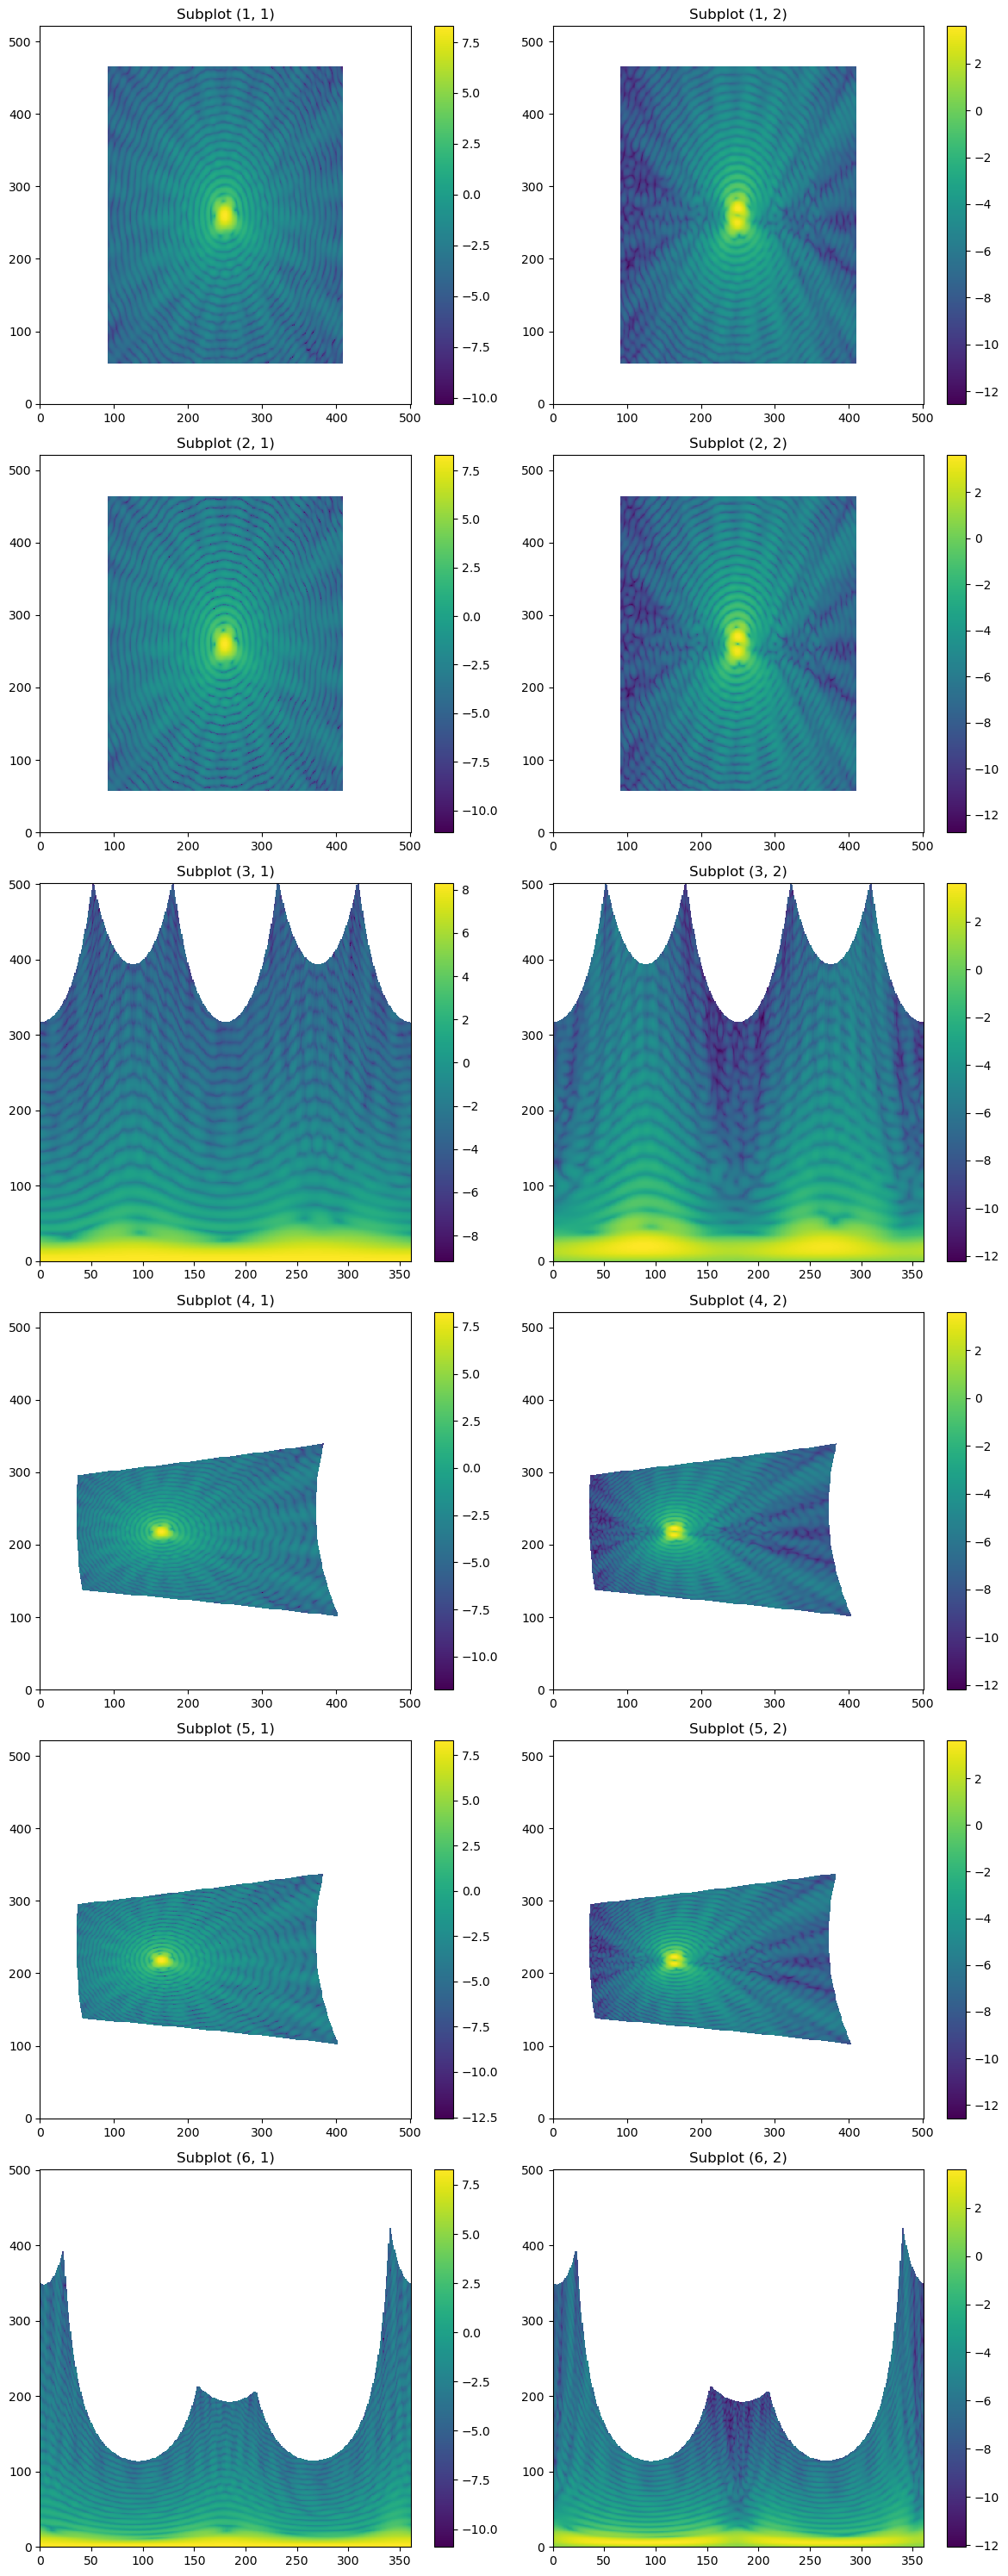

In [22]:
# THIS IS WITHOUT FLIPPING IN V

def read_matlab_v7_3_file(file_path):
    def recursively_extract_data(hdf5_group):
        group_dict = {}
        for key, item in hdf5_group.items():
            if isinstance(item, h5py.Dataset):
                group_dict[key] = item[()]
            elif isinstance(item, h5py.Group):
                group_dict[key] = recursively_extract_data(item)
        return group_dict

    with h5py.File(file_path, 'r') as f:
        data_dict = recursively_extract_data(f)

    return data_dict

# Print the keys and some example data to verify
def print_dict_structure(d, indent=0):
    for key, value in d.items():
        print(' ' * indent + str(key))
        if isinstance(value, dict):
            print_dict_structure(value, indent + 2)
        else:
            print(' ' * (indent + 2) + f"Type: {type(value)}, Shape: {value.shape if isinstance(value, np.ndarray) else 'N/A'}")
            # Print first few elements for arrays
            if isinstance(value, np.ndarray):
                print(' ' * (indent + 2) + f"Data: {value.ravel()[:5]}")


file_path = pathlib.Path(f'{root_dir}/output/integrated/cimr_apat_hbs.C_Horn_01.ds_001.uv.ave.sample.mat').resolve()  # Replace with the actual path to your .mat file
cimr = read_matlab_v7_3_file(file_path)

#print_dict_structure(cimr)


print(cimr['C_Horn_01']['apat'].keys())

apat_list = ['apat',  'apat_inst', 'apat_uv_polar', 'apat_xy_cart', 'apat_xy_cart_inst', 'apat_xy_polar'] #'apat_hv',
mueller_list = ['M33', 'Mxy']

# Example function to generate data for pcolor
def generate_example_data(shape):
    return np.random.rand(*shape)

rows = 6
cols = 2
# Create the figure and 6x2 grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 30))

# Iterate over the axes to populate each subplot
for i in range(rows):
    print(i, apat_list[i])
    for j in range(cols):
        ax = axes[i, j]
        #data = generate_example_data((10, 10))  # Generate example data
        data = np.log10(np.abs(cimr['C_Horn_01'][apat_list[i]][mueller_list[j]]**2))
        c = ax.pcolor(data, cmap='viridis', shading='auto')
        fig.colorbar(c, ax=ax)
        ax.set_title(f'Subplot ({i+1}, {j+1})')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()



### Grid conversion 

$$
\hat{r} = \left(u, v, \sqrt{1-u^2-v^2}\right)
$$
So to get from Cartesian $(u,v)$ to spherical $(\theta, \phi)$:  
$$
u=\sin\theta\cos\phi
$$
$$
v=\sin\theta\sin\phi
$$
$$
\sqrt{1-u^2-v^2} = \cos\theta
$$
we need to 
$$
\theta=\arccos{\sqrt{1-u^2-v^2}}
$$
$$
\frac{v}{u} = \tan\phi, \quad \rightarrow \quad \phi = \arctan\left(\frac{v}{u}\right)
$$

[__Note__]: Due to numerical issues, we cannot simply use formulae for $\phi$, instead we are going to use $\phi=\arctan2(v,u)$

In [ ]:
$$
u^2 + v^2 = \left(\sin\theta\cos\phi\right)^2 + \left(\sin\theta\sin\phi\right)^2 = \sin^2\phi
$$